In [ ]:
#! pip install delayed
! pip install --upgrade pip
! pip install --upgrade scikit-learn
! pip install PyDrive
! pip install pyyaml==5.4.1
! pip install sentence-transformers
! pip install unidecode
! pip install  openpyxl==3.0.0

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold
import xgboost as xgb
from google.colab import drive
from sklearn.metrics import classification_report, precision_recall_curve, accuracy_score
from matplotlib import pyplot
from sklearn.metrics import confusion_matrix
import seaborn as sns
from numpy import vstack
from numpy import argmax
from pandas import read_csv
from torch import Tensor
#from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Softmax
from torch.nn import Module
from torch.optim import SGD
from torch.nn import CrossEntropyLoss
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
from tabulate import tabulate

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn



# Load data

In [4]:
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
cd '/content/drive/Shareddrives/RENAULT PROJECT DRIVE/202201-Categorisation-DRG /data/'

/content/drive/Shareddrives/RENAULT PROJECT DRIVE/202201-Categorisation-DRG /data


In [6]:
ls

df_corpus_top5.csv  df_top5.csv  evaluation/  interim/    raw/
df_test_top5.csv    embedded/    hard/        processed/


# Utils

In [7]:
def label_encode_row(x):
  """Label encodes values. 
    
  Args:
      x (df): dataframe to label encode
  Returns:
      x (df): label encoded dataframe                                         

  """
  x, _ = pd.factorize(x)
  return x

In [8]:
def transform_data(df,columns_to_Encod):
  """Function to transform data.
  Args:
      df (pd.DataFrame):  input to transform                            
      columns_to_Encod (list) :   columns to encode                      
  Returns:
      df (pd.DataFrame):       data  transformed
  """
  df_=df.copy()
  Cols=['label_pred_1', 'label_pred_2','label_pred_3', 'label_pred_4','label_pred_5']
  df_['label_true_original'] =df_['label_true']
  
  df_[columns_to_Encod]=pd.DataFrame(df_[columns_to_Encod].apply(label_encode_row, axis=1).to_list(), columns=columns_to_Encod)

  df_['label_true']=df_['label_true'].mask((df_[Cols].values != df_[['label_true']].values).all(axis=1).astype(int)== 1, 5, axis=0)



  df_dummies=pd.get_dummies(df_[columns_to_Encod[:-1]], columns=columns_to_Encod[:-1])
  df_all_Feature = pd.concat([df_, df_dummies], axis=1)


  return df_all_Feature

In [9]:
def test_transform_data(columns_to_Encod):
  test_frame = pd.DataFrame(data=[df_corpus_top5.iloc[0].values], columns=df_corpus_top5.columns)
  table_input = tabulate(test_frame,headers=test_frame.columns, tablefmt='github')
  print("\033[0;32;47m    Input  :  \n")
  print("\033[0;32;47m "+table_input)
  result=transform_data(test_frame,columns_to_Encod)
  print("\n")
  print("\033[0;32;47m  Outout  :  \n")
  table_output = tabulate(result,headers=result.columns, tablefmt='github')
  print("\033[0;32;47m "+table_output)


In [10]:
# model_selection function : just to get an idea about the general performance of each model
def model_selection(X, y):
    iteration = 0
    k = 7
    models = {
        "K-nn": [],
        "Naive_Bayes": [],
        "Logistic_Regression": [],
        "SVM": [],
        "Random_Forest": [],
        "Ada-Boost": [],
        'Xg_Boost': []
    }
    kf = KFold(n_splits=k, )
    kf.get_n_splits(X)

    neigh = KNeighborsClassifier(n_neighbors=4)
    naive_b = GaussianNB()
    lr = LogisticRegression()
    SVM = svm.SVC()
    rf = RandomForestClassifier()
    for train_index, test_index in kf.split(X):
        #print("Iteration:", iteration)
        #iteration += 1
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]


        neigh.fit(X_train, y_train)
        models['K-nn'].append(neigh.score(X_test, y_test))


        naive_b.fit(X_train, y_train)
        models['Naive_Bayes'].append(naive_b.score(X_test, y_test))

        lr.fit(X_train, y_train)
        models['Logistic_Regression'].append(lr.score(X_test, y_test))


        SVM.fit(X_train, y_train)
        models['SVM'].append(SVM.score(X_test, y_test))


        rf.fit(X_train, y_train)
        models['Random_Forest'].append(rf.score(X_test, y_test))
        
        ada_b = AdaBoostClassifier(n_estimators=20,)
        ada_b.fit(X_train, y_train)
        models['Ada-Boost'].append(ada_b.score(X_test, y_test))

        xgb_model = xgb.XGBClassifier()
        xgb_model.fit(X_train, y_train)
        models['Xg_Boost'].append(xgb_model.score(X_test, y_test))

        
    model_evaluation_dict = {}
    for model in models.keys():
        model_evaluation_dict[model] = [np.mean(models[model])]
    df_evaluation = pd.DataFrame.from_dict(model_evaluation_dict)
    df_evaluation = df_evaluation.rename(index = {0 : 'Accuracy'})
    return df_evaluation

In [ ]:
# hello raed

In [ ]:
def benchmark_ML_models(X_train, X_test,y_train, y_test,dff):

    models = {
        "K-nn": [],
        "Naive_Bayes": [],
        "Logistic_Regression": [],
        "SVM": [],
        "Random_Forest": [],
        "Ada-Boost": [],
        'Xg_Boost': []
    }


    KNeighbors = KNeighborsClassifier(n_neighbors=4)
    naive_b = GaussianNB()
    lr = LogisticRegression()
    SVM = svm.SVC(probability=True,)
    rf = RandomForestClassifier()



    KNeighbors.fit(X_train, y_train)
    #models['K-nn'].append(KNeighbors.score(X_test, y_test))
    predKNeighbors = KNeighbors.predict(X_test)
    probsKNeighbors = KNeighbors.predict_proba(X_test)
    probsKNeighbors_max= np.max(probsKNeighbors, axis=1) 


    naive_b.fit(X_train, y_train)
    #models['Naive_Bayes'].append(naive_b.score(X_test, y_test))
    prednaive_b = naive_b.predict(X_test)
    probsnaive_b = naive_b.predict_proba(X_test)
    probsnaive_b_max= np.max(probsnaive_b, axis=1) 



    lr.fit(X_train, y_train)
    #models['Logistic_Regression'].append(lr.score(X_test, y_test))
    predLogistic_Regression = lr.predict(X_test)
    probsLogistic_Regression = lr.predict_proba(X_test)
    probsprobsLogistic_Regression_max= np.max(probsLogistic_Regression, axis=1) 


    SVM.fit(X_train, y_train)
    #models['SVM'].append(SVM.score(X_test, y_test))
    predSVM = SVM.predict(X_test)
    probsSVM = SVM.predict_proba(X_test)
    probsprobsSVM_max= np.max(probsSVM, axis=1) 


    rf.fit(X_train, y_train)
    #models['Random_Forest'].append(rf.score(X_test, y_test))
    predRandom_Forest = rf.predict(X_test)
    probsRandom_Forest = rf.predict_proba(X_test)
    probsRandom_Forest_max= np.max(probsRandom_Forest, axis=1) 
    
    ada_b = AdaBoostClassifier(n_estimators=20,)
    ada_b.fit(X_train, y_train)
    #models['Ada-Boost'].append(ada_b.score(X_test, y_test))
    predada_b = ada_b.predict(X_test)
    probsada_b = ada_b.predict_proba(X_test)
    probsprobsada_b_max= np.max(probsada_b, axis=1) 



    xgb_model = xgb.XGBClassifier()
    xgb_model.fit(X_train, y_train)
    #models['Xg_Boost'].append(xgb_model.score(X_test, y_test))
    predXg_Boost = xgb_model.predict(X_test)
    probsXg_Boost = xgb_model.predict_proba(X_test)
    probsprobsXg_Boost_max= np.max(probsXg_Boost, axis=1) 

    #pred=[predKNeighbors,prednaive_b,predLogistic_Regression,predSVM,predRandom_Forest,predada_b,predXg_Boost]
    #probs=[probsKNeighbors_max,probsnaive_b_max,probsprobsLogistic_Regression_max,probsprobsSVM_max,probsRandom_Forest_max,probsprobsada_b_max,probsprobsXg_Boost_max]
    pred = {
        "K-nn": predKNeighbors,
        "Naive_Bayes": prednaive_b,
        "Logistic_Regression": predLogistic_Regression,
        "SVM": predSVM,
        "Random_Forest":predRandom_Forest,
        "Ada-Boost": predada_b,
        'Xg_Boost': predXg_Boost
    }

    probs = {
        "K-nn": probsKNeighbors_max,
        "Naive_Bayes": probsnaive_b_max,
        "Logistic_Regression": probsprobsLogistic_Regression_max,
        "SVM": probsprobsSVM_max,
        "Random_Forest":probsRandom_Forest_max,
        "Ada-Boost": probsprobsada_b_max,
        'Xg_Boost': probsprobsXg_Boost_max
    }
    for i in models:
      dff[i+"_prediction"]=pred[i]
      dff[i+"_score"]=probs[i]


    return dff

#Feature engineering


In [ ]:
df_corpus_top5 = pd.read_csv('df_corpus_top5.csv',sep=',')
df_corpus_top5 = df_corpus_top5.drop(columns=["Unnamed: 0"])
df_corpus_top5.head(3)

,score_1,score_2,score_3,score_4,score_5,label_pred_1,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_true,is_pred_1_correct,is_pred_2_correct,is_pred_3_correct,is_pred_4_correct,is_pred_5_correct,is_top3_correct,is_top5_correct
0,0.738368,0.717175,0.714135,0.707027,0.706180,wrong designation,"message ""sos to check""",reset adac,message sos to control,message sos to control,out of scope,0,0,0,0,0,0,0
1,0.713122,0.684600,0.674399,0.672508,0.668059,black screen,black screen,reset adac,tachometer needle freeze,reset adac,aspect issue,0,0,0,0,0,0,0
2,0.618209,0.610258,0.599718,0.589054,0.578812,display issue,display issue,display issue,aspect issue,settings issue,aspect issue,0,0,0,1,0,0,1


In [ ]:
df_test_top5 = pd.read_csv('df_test_top5.csv',sep=',')
df_test_top5 = df_test_top5.drop(columns=["Unnamed: 0"])
df_test_top5.head(3)

,score_1,score_2,score_3,score_4,score_5,label_pred_1,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_true,is_pred_1_correct,is_pred_2_correct,is_pred_3_correct,is_pred_4_correct,is_pred_5_correct,is_top3_correct,is_top5_correct
0,0.710615,0.706026,0.666258,0.664980,0.658934,black screen,reception issue ( fm am dab gps),antenna issue,replication issue,black screen,antenna issue,0,0,1,0,0,1,1
1,0.737935,0.703151,0.699834,0.696477,0.692233,black screen,inexploitable,black screen,display freeze,ecu update,error message,0,0,0,0,0,0,0
2,0.757152,0.736345,0.720983,0.714639,0.712411,black screen,black screen,black screen,reception issue ( fm am dab gps),camera issue,replication issue,0,0,0,0,0,0,0


In [ ]:
columns_to_encod = ['label_pred_1',
                   'label_pred_2',
                   'label_pred_3',
                   'label_pred_4',
                   'label_pred_5',
                   'label_true',]

In [ ]:
test_transform_data(columns_to_encod)

    Input  :  

 |    |   score_1 |   score_2 |   score_3 |   score_4 |   score_5 | label_pred_1      | label_pred_2           | label_pred_3   | label_pred_4           | label_pred_5           | label_true   |   is_pred_1_correct |   is_pred_2_correct |   is_pred_3_correct |   is_pred_4_correct |   is_pred_5_correct |   is_top3_correct |   is_top5_correct |
|----|-----------|-----------|-----------|-----------|-----------|-------------------|------------------------|----------------|------------------------|------------------------|--------------|---------------------|---------------------|---------------------|---------------------|---------------------|-------------------|-------------------|
|  0 |  0.738368 |  0.717175 |  0.714135 |  0.707027 |   0.70618 | wrong designation | message "sos to check" | reset adac     | message sos to control | message sos to control | out of scope |                   0 |                   0 |                   0 |                   0 |              

In [ ]:
df_train=transform_data(df_corpus_top5,columns_to_encod)
df_test=transform_data(df_test_top5,columns_to_encod)

In [ ]:
score_features = [ 'score_1', 'score_2', 'score_3', 'score_4', 'score_5']
label_pred_features = ['label_pred_1','label_pred_2', 'label_pred_3', 'label_pred_4', 'label_pred_5']
is_pred_correct_features = ['is_pred_1_correct', 'is_pred_2_correct','is_pred_3_correct','is_pred_4_correct', 'is_pred_5_correct','is_top3_correct','is_top5_correct',]
label_pred_dummies_features = ['label_pred_1_0','label_pred_2_0', 'label_pred_2_1', 'label_pred_3_0', 'label_pred_3_1','label_pred_3_2','label_pred_4_0', 'label_pred_4_1','label_pred_4_2','label_pred_4_3', 'label_pred_5_0', 'label_pred_5_1', 'label_pred_5_2','label_pred_5_3', 'label_pred_5_4']

In [ ]:
X_train = df_train[ score_features + label_pred_features + label_pred_dummies_features  ]
y_train = df_train[['label_true']]   

X_test = df_test[ score_features + label_pred_features + label_pred_dummies_features ]
y_test = df_test[['label_true']]     

# Modeling

### Opted for the following classification models:
- Naive Bayes
- KNN
- Logistic Regression
- Random Forest
- SVM
- Ada-Boost
- XG-Boost

## As a method for estimating the reliability of machine learning models, we used K-Fold Cross Validation

In [ ]:
# Without  is_pred_K_correct
model_selection(X_train,y_train)

,K-nn,Naive_Bayes,Logistic_Regression,SVM,Random_Forest,Ada-Boost,Xg_Boost
Accuracy,0.533666,0.503971,0.601113,0.591817,0.555657,0.476416,0.596692


In [ ]:
# Only score
model_selection(X_train,y_train)

,K-nn,Naive_Bayes,Logistic_Regression,SVM,Random_Forest,Ada-Boost,Xg_Boost
Accuracy,0.438904,0.496146,0.506235,0.508276,0.465199,0.491269,0.508842


In [ ]:
# Oll feature  
model_selection(X_train   ,  y_train)  # overfitting

,K-nn,Naive_Bayes,Logistic_Regression,SVM,Random_Forest,Ada-Boost,Xg_Boost
Accuracy,0.999547,0.965201,0.998414,1.0,1.0,0.89968,1.0


# benchmark models ML

In [ ]:
columns=["label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_pred_1"	,"label_true_original","label_true"]
df_assess=df_test[columns]

In [ ]:
# For each model we will get the prediction and the score 
df_assess_all=benchmark_ML_models(X_train, X_test,y_train, y_test,df_assess)

In [ ]:
df_assess_all

,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_pred_1,label_true_original,label_true,K-nn_prediction,K-nn_score,Naive_Bayes_prediction,...,Logistic_Regression_prediction,Logistic_Regression_score,SVM_prediction,SVM_score,Random_Forest_prediction,Random_Forest_score,Ada-Boost_prediction,Ada-Boost_score,Xg_Boost_prediction,Xg_Boost_score
0,1,2,3,0,0,antenna issue,2,5,0.50,5,...,5,0.516339,5,0.509727,5,0.57,5,0.202796,5,0.542464
1,1,0,2,3,0,error message,5,0,0.25,5,...,5,0.446518,5,0.516250,5,0.43,5,0.202796,5,0.412978
2,0,0,1,2,0,replication issue,5,0,0.50,0,...,0,0.625791,0,0.642304,2,0.43,0,0.228985,0,0.595768
3,1,2,0,2,0,mechanical noise,5,0,0.75,5,...,5,0.500588,0,0.634326,0,0.53,0,0.201936,5,0.423981
4,1,2,1,1,0,black screen,1,1,0.50,1,...,5,0.411102,1,0.451395,2,0.62,5,0.198479,1,0.389565
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
812,0,1,1,2,0,reset adac,5,0,0.75,5,...,5,0.585876,0,0.580878,0,0.54,5,0.329609,0,0.305761
813,1,2,3,1,0,fuel gauge issue,2,1,0.75,2,...,5,0.401019,5,0.492010,1,0.58,2,0.211369,5,0.374731
814,0,1,0,0,0,reset adac,1,0,0.50,0,...,0,0.762626,0,0.645201,0,0.66,0,0.222870,0,0.669881
815,1,1,2,1,0,fuel gauge issue,2,1,0.50,1,...,1,0.464936,5,0.386587,1,0.46,0,0.202827,1,0.611320


# hyperparameters optimization

## Random Forest 

In [ ]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 1200, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt', 'log2',None]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'criterion' :['gini', 'entropy'],
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)

{'n_estimators': [200, 311, 422, 533, 644, 755, 866, 977, 1088, 1200], 'max_features': ['auto', 'sqrt', 'log2', None], 'criterion': ['gini', 'entropy'], 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110, None], 'min_samples_split': [2, 5, 10], 'min_samples_leaf': [1, 2, 4], 'bootstrap': [True, False]}


In [ ]:
# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf,
                               param_distributions = random_grid,
                               n_iter = 100,
                               cv = 2,
                               verbose=2,
                               random_state=42,
                               n_jobs = -1)# Fit the random search model
rf_random.fit(X_train, y_train)

Fitting 2 folds for each of 100 candidates, totalling 200 fits


RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=100,
                   n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'criterion': ['gini', 'entropy'],
                                        'max_depth': [10, 20, 30, 40, 50, 60,
                                                      70, 80, 90, 100, 110,
                                                      None],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [200, 311, 422, 533,
                                                         644, 755, 866, 977,
                                                         1088, 1200]},
                   random_

In [ ]:
rf_random.best_params_

{'bootstrap': True,
 'criterion': 'gini',
 'max_depth': 10,
 'max_features': 'sqrt',
 'min_samples_leaf': 4,
 'min_samples_split': 5,
 'n_estimators': 311}

In [ ]:
model = RandomForestClassifier( )
model.fit(X_train, y_train)
print(model.score(X_test,y_test))
best_model = rf_random.best_estimator_
print(best_model.score(X_test,y_test))

0.42105263157894735
0.45532435740514077


Accuracy is:  0.45532435740514077


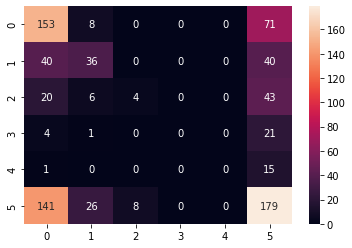

In [ ]:
ac = accuracy_score(y_test,best_model.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,best_model.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
y_test, y_pred_random_forest = y_test, best_model.predict(X_test)
print(classification_report(y_test, y_pred_random_forest))

              precision    recall  f1-score   support

           0       0.43      0.66      0.52       232
           1       0.47      0.31      0.37       116
           2       0.33      0.05      0.09        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.51      0.50       354

    accuracy                           0.46       817
   macro avg       0.29      0.26      0.25       817
weighted avg       0.43      0.46      0.42       817



Feature ranking:
1. feature 0 (0.101855)
2. feature 12 (0.084027)
3. feature 1 (0.082999)
4. feature 2 (0.077708)
5. feature 3 (0.077198)
6. feature 4 (0.076443)
7. feature 6 (0.073862)
8. feature 11 (0.054820)
9. feature 7 (0.053512)
10. feature 8 (0.045717)
11. feature 9 (0.041347)
12. feature 13 (0.040647)
13. feature 16 (0.036398)
14. feature 15 (0.028584)
15. feature 20 (0.024028)
16. feature 14 (0.022604)
17. feature 17 (0.017328)
18. feature 21 (0.014513)
19. feature 18 (0.014395)
20. feature 22 (0.011308)
21. feature 19 (0.008902)
22. feature 23 (0.008322)
23. feature 24 (0.003485)
24. feature 5 (0.000000)
25. feature 10 (0.000000)


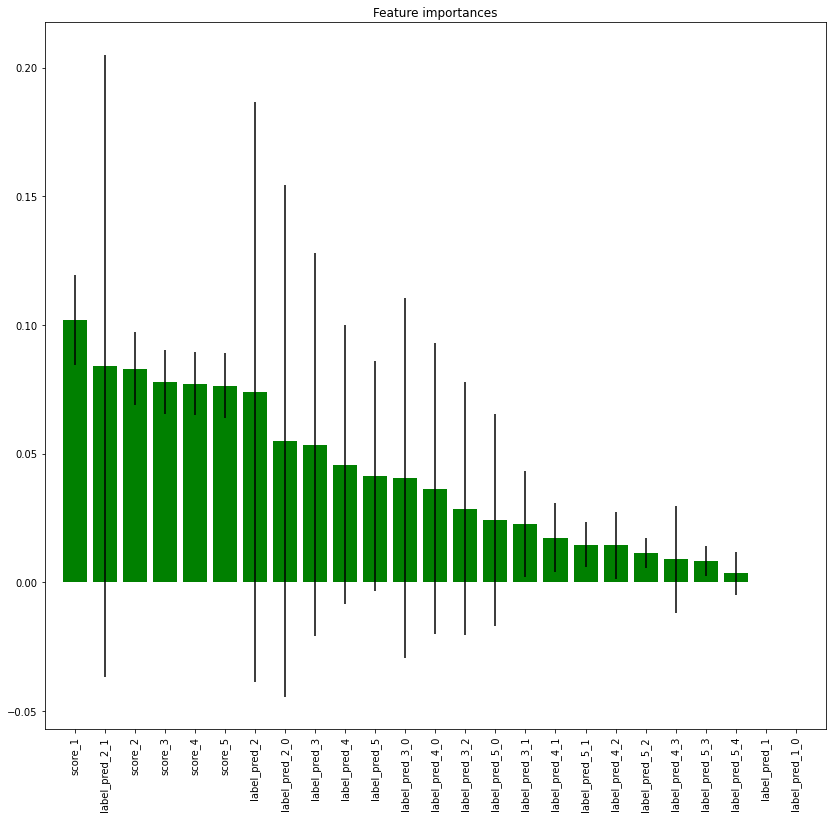

In [ ]:
# feature importances
importances = best_model.feature_importances_
std = np.std([tree.feature_importances_ for tree in best_model.estimators_],
             axis=0)
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X_train.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]]))

# Plot the feature importances of the forest

plt.figure(1, figsize=(14, 13))
plt.title("Feature importances")
plt.bar(range(X_train.shape[1]), importances[indices],
       color="g", yerr=std[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices],rotation=90)
plt.xlim([-1, X_train.shape[1]])
plt.show()

In [ ]:
df_assess=df_test[score_features + label_pred_features+ ["label_true"]]
df_assess["rf_pred"]=y_pred_random_forest
df_assess["rf_score"]=np.max(best_model.predict_proba(X_test), axis=1)

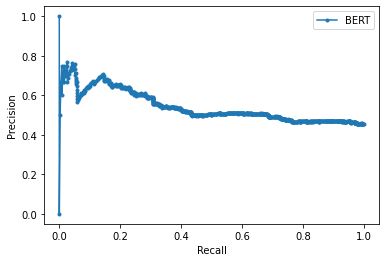

Best Threshold=0.891871, precision=0.769

               precision    recall  f1-score   support

           0       0.54      1.00      0.71       445
           1       0.00      0.00      0.00       372

    accuracy                           0.54       817
   macro avg       0.27      0.50      0.35       817
weighted avg       0.30      0.54      0.38       817

----------------------------------

               precision    recall  f1-score   support

           0       0.55      0.99      0.71       445
           1       0.75      0.02      0.05       372

    accuracy                           0.55       817
   macro avg       0.65      0.51      0.38       817
weighted avg       0.64      0.55      0.41       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"
# classification label 
df_assess['compare_between_true_and_rf_label'] = np.where(
    df_assess['rf_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_rf_label"].to_list(), df_assess.rf_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_rf_label"].to_list()

# "visually" determined value
y_preds = [1 if x == 0.5 else 0 for x in df_assess.rf_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.rf_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_random_forest, zero_division=0))


               precision    recall  f1-score   support

           0       0.43      0.66      0.52       232
           1       0.47      0.31      0.37       116
           2       0.33      0.05      0.09        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.51      0.50       354

    accuracy                           0.46       817
   macro avg       0.29      0.26      0.25       817
weighted avg       0.43      0.46      0.42       817



## ADA-BOOST

In [ ]:
def adaboust_best_param(X_final, y):
    ada_dict = {}
    # Split the dataset in two equal parts
    X_train, X_test, y_train, y_test = train_test_split(X_final, y, test_size=0.3, random_state=0)
    for n in [10,20,30,40,50]:
        model = AdaBoostClassifier(DecisionTreeClassifier(max_depth = 1, # Just a stump.
                                   random_state = np.random.RandomState(0)),
                                   n_estimators = n,
                                   random_state = np.random.RandomState(0))
        model.fit(X_train, y_train)
        ada_dict[n] = [model.score(X_train, y_train)]
    df_evaluation = pd.DataFrame.from_dict(ada_dict)
    df_evaluation = df_evaluation.rename(index = {0 : 'Score'})
    return df_evaluation

In [ ]:
adaboust_best_param(X_train, y_train)

,10,20,30,40,50
Score,0.540729,0.54753,0.50996,0.518866,0.508826


In [ ]:
AdaBoos_model = AdaBoostClassifier(n_estimators=20, random_state=0)
AdaBoos_model.fit(X_train, y_train)
y_pred_AdaB = AdaBoos_model.predict(X_test)
AdaBoos_model.score(X_test, y_test)

0.40269277845777235

In [ ]:
print(classification_report(y_test, y_pred_AdaB))

              precision    recall  f1-score   support

           0       0.37      0.61      0.46       232
           1       0.25      0.16      0.19       116
           2       0.40      0.03      0.05        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.47      0.47      0.47       354

    accuracy                           0.40       817
   macro avg       0.25      0.21      0.20       817
weighted avg       0.38      0.40      0.37       817



Accuracy is:  0.40269277845777235


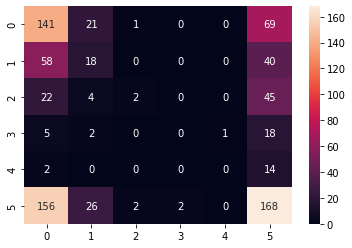

In [ ]:
ac = accuracy_score(y_test,AdaBoos_model.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,AdaBoos_model.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
df_assess=df_test[score_features + label_pred_features+ ["label_true"]]
df_assess["AdaB_pred"]=y_pred_AdaB
df_assess["AdaB_score"]=np.max(AdaBoos_model.predict_proba(X_test), axis=1)

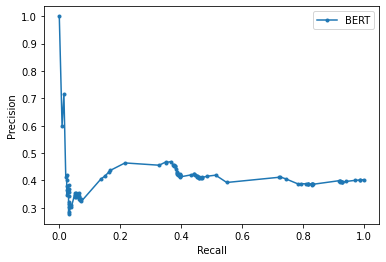

Best Threshold=0.329609, precision=0.714

               precision    recall  f1-score   support

           0       0.60      1.00      0.75       488
           1       0.00      0.00      0.00       329

    accuracy                           0.60       817
   macro avg       0.30      0.50      0.37       817
weighted avg       0.36      0.60      0.45       817

----------------------------------

               precision    recall  f1-score   support

           0       0.60      1.00      0.75       488
           1       0.60      0.01      0.02       329

    accuracy                           0.60       817
   macro avg       0.60      0.50      0.38       817
weighted avg       0.60      0.60      0.45       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"
# classification label 
df_assess['compare_between_true_and_AdaB_label'] = np.where(
    df_assess['AdaB_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_AdaB_label"].to_list(), df_assess.AdaB_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_AdaB_label"].to_list()

# "visually" determined value
y_preds = [1 if x == 0.5 else 0 for x in df_assess.AdaB_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.AdaB_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_AdaB, zero_division=0))


               precision    recall  f1-score   support

           0       0.37      0.61      0.46       232
           1       0.25      0.16      0.19       116
           2       0.40      0.03      0.05        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.47      0.47      0.47       354

    accuracy                           0.40       817
   macro avg       0.25      0.21      0.20       817
weighted avg       0.38      0.40      0.37       817



## XG-BOOST

In [ ]:
xgb_model = xgb.XGBClassifier()
params = {
            'eta': np.arange(0.1, 0.26, 0.05),
            'min_child_weight': np.arange(1, 5, 0.5).tolist(),
            'gamma': [5],
            'subsample': np.arange(0.5, 1.0, 0.11).tolist(),
            'colsample_bytree': np.arange(0.5, 1.0, 0.11).tolist()
        }

skf = StratifiedKFold(n_splits=10, shuffle = True)

grid = GridSearchCV(xgb_model, 
                    param_grid = params,  
                    n_jobs = -1, 
                    cv = skf.split(X_train, y_train),
                    refit = "accuracy_score")

grid.fit(X_train, y_train)
# Dictionary of best parameters
best_pars = grid.best_params_

In [ ]:
best_pars

{'colsample_bytree': 0.61,
 'eta': 0.1,
 'gamma': 5,
 'min_child_weight': 2.5,
 'subsample': 0.72}

In [ ]:
xgb_model = xgb.XGBClassifier(colsample_bytree=0.5,
 eta=0.1,
 gamma= 5,
 min_child_weight=1.5,
 subsample= 0.94)

In [ ]:
xgbc=xgb_model.fit(X_train, y_train)
y_pred_xgb = xgbc.predict(X_test)
report = classification_report(y_test,y_pred_xgb)
print(report)

              precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.50      0.23      0.32       116
           2       0.27      0.04      0.07        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.53      0.51       354

    accuracy                           0.46       817
   macro avg       0.28      0.25      0.24       817
weighted avg       0.43      0.46      0.42       817



Accuracy is:  0.46266829865361075


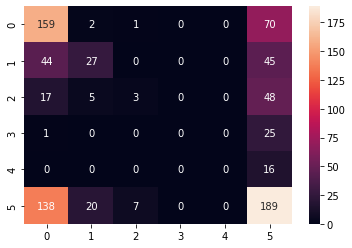

In [ ]:
ac = accuracy_score(y_test,xgb_model.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,xgb_model.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
columns=["score_1","label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_true_original","label_pred_1"	,"label_true",]
df_assess=df_test[columns]

In [ ]:
df_assess["xgb_pred"]=y_pred_xgb
df_assess["xgb_score"]=np.max(xgb_model.predict_proba(X_test), axis=1)

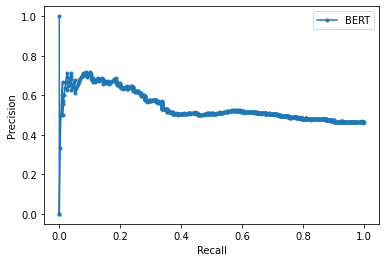

Best Threshold=0.821231, precision=0.717

               precision    recall  f1-score   support

           0       0.54      1.00      0.70       439
           1       0.00      0.00      0.00       378

    accuracy                           0.54       817
   macro avg       0.27      0.50      0.35       817
weighted avg       0.29      0.54      0.38       817

----------------------------------

               precision    recall  f1-score   support

           0       0.55      0.97      0.70       439
           1       0.71      0.08      0.15       378

    accuracy                           0.56       817
   macro avg       0.63      0.53      0.43       817
weighted avg       0.63      0.56      0.45       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"
# classification label 
df_assess['compare_between_true_and_xgb_label'] = np.where(
    df_assess['xgb_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_xgb_label"].to_list(), df_assess.xgb_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_xgb_label"].to_list()

# "visually" determined value
y_preds = [1 if x == 0.5 else 0 for x in df_assess.xgb_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.xgb_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_xgb, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.50      0.23      0.32       116
           2       0.27      0.04      0.07        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.53      0.51       354

    accuracy                           0.46       817
   macro avg       0.28      0.25      0.24       817
weighted avg       0.43      0.46      0.42       817



## KNN

In [ ]:
knn = KNeighborsClassifier()

parameters = {'n_neighbors':[3,4,5,6,7,8,9,10],
              'leaf_size':[1,3,5],
              'algorithm':['auto', 'kd_tree'],
              'n_jobs':[-1]}

#Fit the model
knn_model = GridSearchCV(knn, param_grid=parameters,cv=2)
knn_model.fit(X_train,y_train)

GridSearchCV(cv=2, estimator=KNeighborsClassifier(),
             param_grid={'algorithm': ['auto', 'kd_tree'],
                         'leaf_size': [1, 3, 5], 'n_jobs': [-1],
                         'n_neighbors': [3, 4, 5, 6, 7, 8, 9, 10]})

In [ ]:
knn_model_best = knn_model.best_params_
knn_model_best

{'algorithm': 'auto', 'leaf_size': 1, 'n_jobs': -1, 'n_neighbors': 10}

In [ ]:
y_pred_knn= knn_model.predict(X_test) 
report = classification_report(y_test,y_pred_knn)
print(report) 

              precision    recall  f1-score   support

           0       0.44      0.71      0.54       232
           1       0.36      0.26      0.30       116
           2       0.19      0.07      0.10        73
           3       0.11      0.08      0.09        26
           4       0.00      0.00      0.00        16
           5       0.48      0.42      0.45       354

    accuracy                           0.43       817
   macro avg       0.26      0.26      0.25       817
weighted avg       0.40      0.43      0.40       817



Accuracy is:  0.4283965728274174


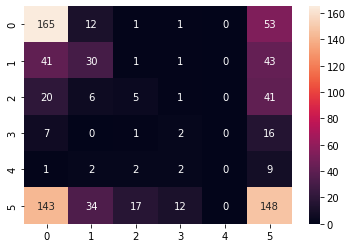

In [ ]:
ac = accuracy_score(y_test,knn_model.predict(X_test))
print('Accuracy is: ',ac)
cm = confusion_matrix(y_test,knn_model.predict(X_test))
sns.heatmap(cm,annot=True,fmt="d")

In [ ]:
columns=["score_1","label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_true_original","label_pred_1"	,"label_true",]
df_assess=df_test[columns]

In [ ]:
df_assess["knn_pred"]=y_pred_knn
df_assess["knn_score"]=np.max(knn_model.predict_proba(X_test), axis=1)

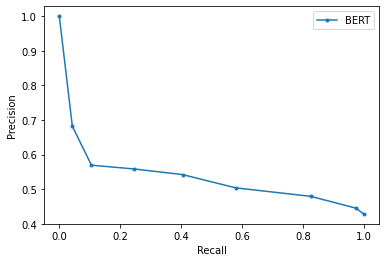

Best Threshold=0.900000, precision=0.569

               precision    recall  f1-score   support

           0       0.57      0.76      0.65       467
           1       0.43      0.25      0.31       350

    accuracy                           0.54       817
   macro avg       0.50      0.50      0.48       817
weighted avg       0.51      0.54      0.51       817

----------------------------------

               precision    recall  f1-score   support

           0       0.58      0.99      0.73       467
           1       0.68      0.04      0.08       350

    accuracy                           0.58       817
   macro avg       0.63      0.51      0.40       817
weighted avg       0.62      0.58      0.45       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"
# classification label 
df_assess['compare_between_true_and_knn_label'] = np.where(
    df_assess['knn_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_knn_label"].to_list(), df_assess.knn_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_knn_label"].to_list()

# "visually" determined value
y_preds = [1 if x == 0.5 else 0 for x in df_assess.knn_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.knn_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_knn, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.71      0.54       232
           1       0.36      0.26      0.30       116
           2       0.19      0.07      0.10        73
           3       0.11      0.08      0.09        26
           4       0.00      0.00      0.00        16
           5       0.48      0.42      0.45       354

    accuracy                           0.43       817
   macro avg       0.26      0.26      0.25       817
weighted avg       0.40      0.43      0.40       817



## SVM

In [ ]:
# Set the parameters by cross-validation
tuned_parameters = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': [1, 10, 100, 1000]},
                    {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}]

scores = ['precision', 'recall']

In [ ]:
for score in scores:
    print("# Tuning hyper-parameters for %s" % score)
    print()

    clf = GridSearchCV(
        svm.SVC(), tuned_parameters, scoring='%s_macro' % score
    )
    clf.fit(X_train, y_train)

    print("Best parameters set found on development set:")
    print()
    print(clf.best_params_)
    print()
    print("Grid scores on development set:")
    print()
    means = clf.cv_results_['mean_test_score']
    stds = clf.cv_results_['std_test_score']
    for mean, std, params in zip(means, stds, clf.cv_results_['params']):
        print("%0.3f (+/-%0.03f) for %r"
              % (mean, std * 2, params))
    print()

    print("Detailed classification report:")
    print()
    print("The model is trained on the full development set.")
    print("The scores are computed on the full evaluation set.")
    print()
    y_true, y_pred = y_test, clf.predict(X_test)
    print(classification_report(y_true, y_pred))
    print()

In [ ]:
svm_model = svm.SVC(probability=True,random_state=0)
svm_model.fit(X_train, y_train)

SVC(probability=True, random_state=0)

In [ ]:
y_test, y_pred_svm = y_test, svm_model.predict(X_test)
print(classification_report(y_test, y_pred_svm))

              precision    recall  f1-score   support

           0       0.42      0.68      0.51       232
           1       0.54      0.25      0.34       116
           2       0.35      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.49      0.48       354

    accuracy                           0.45       817
   macro avg       0.30      0.25      0.25       817
weighted avg       0.43      0.45      0.42       817



In [ ]:
columns=["score_1","label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_true_original","label_pred_1"	,"label_true",]
df_assess=df_test[columns]

In [ ]:
df_assess["svm_pred"]=y_pred_svm
df_assess["svm_score"]=np.max(svm_model.predict_proba(X_test), axis=1)

In [ ]:
df_assess

,score_1,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_true_original,label_pred_1,label_true,svm_label,svm_score,svm_pred
0,0.710615,1,2,3,0,antenna issue,0,2,5,0.561651,5
1,0.737935,1,0,2,3,error message,0,5,5,0.571452,5
2,0.757152,0,0,1,2,replication issue,0,5,0,0.325812,0
3,0.636801,1,2,0,2,mechanical noise,0,5,0,0.321751,0
4,0.643468,1,2,1,1,black screen,0,1,1,0.474380,1
...,...,...,...,...,...,...,...,...,...,...,...
812,0.474088,0,1,1,2,reset adac,0,5,0,0.324221,0
813,0.806806,1,2,3,1,fuel gauge issue,0,2,5,0.508208,5
814,0.706968,0,1,0,0,reset adac,0,1,0,0.319685,0
815,0.763458,1,1,2,1,fuel gauge issue,0,2,5,0.402880,5


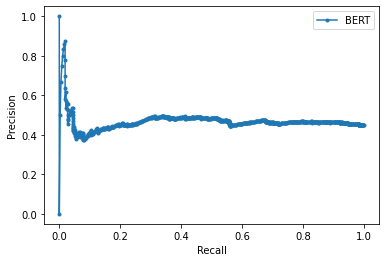

Best Threshold=0.587051, precision=0.875

               precision    recall  f1-score   support

           0       0.58      0.62      0.60       451
           1       0.49      0.45      0.47       366

    accuracy                           0.54       817
   macro avg       0.53      0.53      0.53       817
weighted avg       0.54      0.54      0.54       817

----------------------------------

               precision    recall  f1-score   support

           0       0.56      1.00      0.71       451
           1       0.86      0.02      0.03       366

    accuracy                           0.56       817
   macro avg       0.71      0.51      0.37       817
weighted avg       0.69      0.56      0.41       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"
# classification label 
df_assess['compare_between_true_and_svm_label'] = np.where(
    df_assess['svm_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_svm_label"].to_list(), df_assess.svm_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_svm_label"].to_list()

# "visually" determined value
y_preds = [1 if x > 0.5 else 0 for x in df_assess.svm_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.svm_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_svm, zero_division=0))


               precision    recall  f1-score   support

           0       0.42      0.68      0.51       232
           1       0.54      0.25      0.34       116
           2       0.35      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.49      0.48       354

    accuracy                           0.45       817
   macro avg       0.30      0.25      0.25       817
weighted avg       0.43      0.45      0.42       817



## Logistic Regression 

In [ ]:
lr = LogisticRegression()
lr.fit(X_train,y_train)

LogisticRegression()

In [ ]:
y_pred_lr = lr.predict(X_test) 
report = classification_report(y_test,y_pred_lr)
print(report) 

              precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.51      0.30      0.38       116
           2       0.36      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.50      0.50       354

    accuracy                           0.47       817
   macro avg       0.30      0.27      0.26       817
weighted avg       0.45      0.47      0.44       817



In [ ]:
columns=["score_1","label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_true_original","label_pred_1"	,"label_true",]
df_assess=df_test[columns]

In [ ]:
df_assess["lr_pred"]=lr_predictions
df_assess["lr_score"]=np.max(lr.predict_proba(X_test), axis=1)

In [ ]:
df_assess

,score_1,label_pred_2,label_pred_3,label_pred_4,label_pred_5,label_true_original,label_pred_1,label_true,lr_pred,lr_score
0,0.710615,1,2,3,0,antenna issue,0,2,5,0.516339
1,0.737935,1,0,2,3,error message,0,5,5,0.446518
2,0.757152,0,0,1,2,replication issue,0,5,0,0.625791
3,0.636801,1,2,0,2,mechanical noise,0,5,5,0.500588
4,0.643468,1,2,1,1,black screen,0,1,5,0.411102
...,...,...,...,...,...,...,...,...,...,...
812,0.474088,0,1,1,2,reset adac,0,5,5,0.585876
813,0.806806,1,2,3,1,fuel gauge issue,0,2,5,0.401019
814,0.706968,0,1,0,0,reset adac,0,1,0,0.762626
815,0.763458,1,1,2,1,fuel gauge issue,0,2,1,0.464936


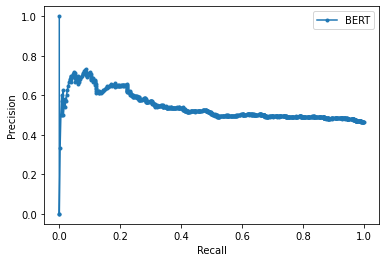

Best Threshold=0.842401, precision=0.733

               precision    recall  f1-score   support

           0       0.57      0.49      0.53       437
           1       0.50      0.57      0.53       380

    accuracy                           0.53       817
   macro avg       0.53      0.53      0.53       817
weighted avg       0.54      0.53      0.53       817

----------------------------------

               precision    recall  f1-score   support

           0       0.55      0.97      0.70       437
           1       0.73      0.08      0.15       380

    accuracy                           0.56       817
   macro avg       0.64      0.53      0.43       817
weighted avg       0.63      0.56      0.45       817



In [ ]:
#TODO WArning : this cell function is different from the on used in the "all models optimization"

df_assess['compare_between_true_and_lr_label_true'] = np.where(
    df_assess['lr_pred'] == df_assess['label_true'], 1, 0) 
# calculate pr-curve (instead of ROC curve : more appropriate for imbalanced data)
precision, recall, thresholds = precision_recall_curve(df_assess["compare_between_true_and_lr_label_true"].to_list(), df_assess.lr_score.to_list())

# plot the pr curve for the model

pyplot.plot(recall, precision, marker='.', label='BERT')
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
pyplot.legend()
pyplot.show()

precision = precision[:-2]

# locate the index of the largest f score
ix = np.argmax(precision)
print('Best Threshold=%f, precision=%.3f' % (thresholds[ix], precision[ix]))

y = df_assess["compare_between_true_and_lr_label_true"].to_list()

# "visually" determined value
y_preds = [1 if x > 0.5 else 0 for x in df_assess.lr_score.to_list()]
y_preds_opt_thresh = [1 if x >(thresholds[ix]) else 0 for x in df_assess.lr_score.to_list()]

print('\n',classification_report(y,y_preds, zero_division=0))
print("----------------------------------")
print('\n',classification_report(y,y_preds_opt_thresh, zero_division=0))

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,y_pred_lr, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.51      0.30      0.38       116
           2       0.36      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.50      0.50       354

    accuracy                           0.47       817
   macro avg       0.30      0.27      0.26       817
weighted avg       0.45      0.47      0.44       817



# DNN

In [ ]:
COLS=score_features + label_pred_features + label_pred_dummies_features

In [ ]:
# dataset definition

def prepere_data(df_all_Feature):
  # load the csv file as a dataframe
  
  # store the inputs and outputs
  X = df_all_Feature[COLS].values
  y = df_all_Feature['label_true'].values
  # ensure input data is floats
  X = X.astype('float32')
  return X,y


# number of rows in the dataset
def len_data(X):
  return len(X)

# get a row at an index
def getitem(X,y, idx):
    return [X[idx],y[idx]]

# get indexes for train and test rows
def get_splits(X,y, n_test=0.33):
    # determine sizes
    test_size = round(n_test * len(X))
    train_size = len(X) - test_size
    # calculate the split
    return random_split(X,y, [train_size, test_size])

In [ ]:
# load the dataset
dataset = prepere_data(df_train)

In [ ]:


train_dl = DataLoader(df_train, batch_size=32, shuffle=True)
test_dl = DataLoader(df_test, batch_size=1024, shuffle=False)


In [ ]:
print(len(train_dl.dataset), len(test_dl.dataset))

8822 817


In [ ]:
# dataset definition
class CSVDataset(Dataset):
    # load the dataset
    def __init__(self, df_all_Feature):
        # load the csv file as a dataframe
          
        # store the inputs and outputs
        self.X = df_all_Feature[COLS].values
        self.y = df_all_Feature['label_true'].values
        # ensure input data is floats
        self.X = self.X.astype('float32')
        print(self)


    # number of rows in the dataset
    def __len__(self):
        return len(self.X)

    # get a row at an index
    def __getitem__(self, idx):
        return [self.X[idx], self.y[idx]]

    # get indexes for train and test rows
    def get_splits(self, n_test=0.33):
        # determine sizes
        test_size = round(n_test * len(self.X))
        train_size = len(self.X) - test_size
        # calculate the split
        return random_split(self, [train_size, test_size])

# model definition
class MLP(Module):
    # define model elements
    def __init__(self, n_inputs):
        super(MLP, self).__init__()
        # input to first hidden layer
        self.hidden1 = Linear(n_inputs, 10)
        kaiming_uniform_(self.hidden1.weight, nonlinearity='relu')
        self.act1 = ReLU()
        # second hidden layer
        self.hidden2 = Linear(10, 8)
        kaiming_uniform_(self.hidden2.weight, nonlinearity='relu')
        self.act2 = ReLU()
        # third hidden layer and output
        self.hidden3 = Linear(8,6)
        xavier_uniform_(self.hidden3.weight)
        self.act3 = Softmax(dim=1)

    # forward propagate input
    def forward(self, X):
        # input to first hidden layer
        X = self.hidden1(X)
        X = self.act1(X)
        # second hidden layer
        X = self.hidden2(X)
        X = self.act2(X)
        # output layer
        X = self.hidden3(X)
        X = self.act3(X)
        return X

# prepare the dataset
#def prepare_data(df_train, df_test ):
def prepare_data(path_train,path_test):
    # load the dataset
    dataset_train = CSVDataset(path_train)
    dataset_test = CSVDataset(path_test)
    # calculate split
    #train, _splits()
    # prepare data loaderstest = dataset.get
    train_dl = DataLoader(dataset_train, batch_size=32, shuffle=True)
    test_dl = DataLoader(dataset_test, batch_size=1024, shuffle=False)
    return train_dl, test_dl

# train the model
def train_model(train_dl, model):
    # define the optimization
    criterion = CrossEntropyLoss()
    optimizer = SGD(model.parameters(), lr=0.01, momentum=0.9)
    # enumerate epochs
    for epoch in range(500):
        # enumerate mini batches
        for i, (inputs, targets) in enumerate(train_dl):
            # clear the gradients
            optimizer.zero_grad()
            # compute the model output
            yhat = model(inputs)
            # calculate loss
            loss = criterion(yhat, targets)
            # credit assignment
            loss.backward()
            # update model weights
            optimizer.step()
           

# evaluate the model
def evaluate_model(test_dl, model):
    predictions, actuals = list(), list()
    for i, (inputs, targets) in enumerate(test_dl):
        # evaluate the model on the test set
        yhat = model(inputs)
        # retrieve numpy array
        yhat = yhat.detach().numpy()
        actual = targets.numpy()
        # convert to class labels
        yhat = argmax(yhat, axis=1)
        # reshape for stacking
        actual = actual.reshape((len(actual), 1))
        yhat = yhat.reshape((len(yhat), 1))
        # store
        predictions.append(yhat)
        actuals.append(actual)
    predictions, actuals = vstack(predictions), vstack(actuals)
    # calculate accuracy
    acc = accuracy_score(actuals, predictions)
    return acc
# make a class prediction for one row of data
def predict(row, model):
    # convert row to data
    row = Tensor([row])
    # make prediction
    yhat = model(row)
    # retrieve numpy array
    yhat = yhat.detach().numpy()
    return yhat

In [ ]:
train_dl, test_dl = prepare_data(df_train,df_test)
print(len(train_dl.dataset), len(test_dl.dataset))

8822 817


In [ ]:
# define the network
model = MLP(25)
# train the model
train_model(train_dl, model)
# evaluate the model
acc = evaluate_model(test_dl, model)
print('Accuracy: %.3f' % acc)
# make a single prediction 
row = [0.71139216, 0.66471159, 0.66216338, 0.65461689, 0.65377486,
       0.        , 0.        , 1.        , 0.        , 0.        ,
       1.        , 1.        , 0.        , 0.        , 1.        ,
       0.        , 1.        , 0.        , 0.        , 0.        ,
       1.        , 0.        , 0.        , 0.        , 0.        ]
yhat = predict(row, model)
print('Predicted: %s (class=%d)' % (yhat, argmax(yhat)))

Accuracy: 0.464
Predicted: [[9.9999976e-01 8.7998842e-17 1.7934754e-16 3.8933826e-17 9.5086668e-17
  1.9872341e-07]] (class=0)


In [ ]:
pred=[]
for i in range(X_test.shape[0]):
  pred.append(argmax(predict(X_test.iloc[i].values, model)))

In [ ]:
columns=["score_1","label_pred_2"	,"label_pred_3"	,"label_pred_4",	"label_pred_5","label_true_original","label_pred_1"	,"label_true",]
df_assess=df_test[columns]

In [ ]:
df_assess["DNN_label"]=pred

In [ ]:
print('\n',classification_report(y_test,df_assess["label_pred_1"], zero_division=0))


               precision    recall  f1-score   support

           0       0.28      1.00      0.44       232
           1       0.00      0.00      0.00       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.00      0.00      0.00       354

    accuracy                           0.28       817
   macro avg       0.05      0.17      0.07       817
weighted avg       0.08      0.28      0.13       817



In [ ]:
print('\n',classification_report(y_test,pred, zero_division=0))


               precision    recall  f1-score   support

           0       0.42      0.75      0.53       232
           1       0.50      0.28      0.36       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.51      0.49      0.50       354

    accuracy                           0.46       817
   macro avg       0.24      0.25      0.23       817
weighted avg       0.41      0.46      0.42       817



# All results 

In [ ]:
# Random-Forest
print('\n',classification_report(y_test,y_pred_random_forest, zero_division=0))


               precision    recall  f1-score   support

           0       0.43      0.66      0.52       232
           1       0.47      0.31      0.37       116
           2       0.33      0.05      0.09        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.51      0.50       354

    accuracy                           0.46       817
   macro avg       0.29      0.26      0.25       817
weighted avg       0.43      0.46      0.42       817



In [ ]:
# ADA-BOOST
print('\n',classification_report(y_test,y_pred_AdaB, zero_division=0))


               precision    recall  f1-score   support

           0       0.36      0.69      0.47       232
           1       0.00      0.00      0.00       116
           2       0.40      0.03      0.05        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.46      0.48      0.47       354

    accuracy                           0.41       817
   macro avg       0.20      0.20      0.17       817
weighted avg       0.34      0.41      0.34       817



In [ ]:
# XG-BOOST
print('\n',classification_report(y_test,y_pred_xgb, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.50      0.23      0.32       116
           2       0.27      0.04      0.07        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.53      0.51       354

    accuracy                           0.46       817
   macro avg       0.28      0.25      0.24       817
weighted avg       0.43      0.46      0.42       817



In [ ]:
# KNN
print('\n',classification_report(y_test,y_pred_knn, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.71      0.54       232
           1       0.36      0.26      0.30       116
           2       0.19      0.07      0.10        73
           3       0.11      0.08      0.09        26
           4       0.00      0.00      0.00        16
           5       0.48      0.42      0.45       354

    accuracy                           0.43       817
   macro avg       0.26      0.26      0.25       817
weighted avg       0.40      0.43      0.40       817



In [ ]:
# SVM
print('\n',classification_report(y_test,y_pred_svm, zero_division=0))


               precision    recall  f1-score   support

           0       0.42      0.68      0.51       232
           1       0.54      0.25      0.34       116
           2       0.35      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.48      0.49      0.48       354

    accuracy                           0.45       817
   macro avg       0.30      0.25      0.25       817
weighted avg       0.43      0.45      0.42       817



In [ ]:
# LogisticRegression
print('\n',classification_report(y_test,y_pred_lr, zero_division=0))


               precision    recall  f1-score   support

           0       0.44      0.69      0.54       232
           1       0.51      0.30      0.38       116
           2       0.36      0.11      0.17        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.49      0.50      0.50       354

    accuracy                           0.47       817
   macro avg       0.30      0.27      0.26       817
weighted avg       0.45      0.47      0.44       817



In [ ]:
# DNN
print('\n',classification_report(y_test,pred, zero_division=0))


               precision    recall  f1-score   support

           0       0.42      0.75      0.53       232
           1       0.50      0.28      0.36       116
           2       0.00      0.00      0.00        73
           3       0.00      0.00      0.00        26
           4       0.00      0.00      0.00        16
           5       0.51      0.49      0.50       354

    accuracy                           0.46       817
   macro avg       0.24      0.25      0.23       817
weighted avg       0.41      0.46      0.42       817

